In [76]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
gpu = tf.config.experimental.list_physical_devices('GPU')
for g in gpu:
    tf.config.experimental.set_memory_growth(g, True)
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### remove dodgy images (poor quailtiy, outlier, incorrect label etc)

In [3]:
import cv2
import imghdr

In [4]:
data_dir = '/content/drive/MyDrive/datasets/sad_happy_clean_dataset'
os.listdir(data_dir)

['sad', 'happy']

In [5]:
image_exits = ['jpg', 'jpeg', 'png', 'bmp']
image_exits[0]

'jpg'

In [6]:
for image_class in os.listdir(data_dir):
    print(image_class)

sad
happy


In [19]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    print(image)

image36.jpeg
image37.jpeg
3293803510_e96c37cc3e_z1.jpg
people-2567395_640.jpg
kisspng-microphone-finger-shoulder-5d2edf40749772.9128578915633528964776.jpg
depressed-person-standing-alone-bench_23-2150761438.jpg
desktop-wallpaper-depression-sad-mood-sorrow-dark-people-depressed-man.jpg
man-tears-tear-look.jpg
Depression-vs.-Sadness.jpg
sad-people-worried-people-thinking-depression-alone-shoulder-sitting-joint-png-clipart.jpg
l-person-disappointed-of-corporate-job-fail-or-mistake-in-studio-fit_400_400.jpg
sadness-sad-persons-scale-depression-worry-sad-man.jpg
HD-wallpaper-people-love-men-nature-sad-style-thumbnail.jpg
HD-wallpaper-sad-and-alon-alone-box-mom-people-sadness-thumbnail.jpg
960x0.jpg
risis-fight-living-room-couple-breakup-sad-people-depression-anger-312731652.jpg
portrait-young-man-lonely-boring-sad-people-B2GTFD.jpg
sadness-inside-out-today-main-tease-191018.jpg
person-super-depressed.jpg
sadpersonas-risks-symptoms-suicide.jpg
thinking-people-sad-people-worried-people-depres

In [8]:
img = cv2.imread(os.path.join(data_dir, 'sad', '214-2142366_transparent-depression-png-depressed-sad-person-png-png.png'))
img.shape

(1075, 860, 3)

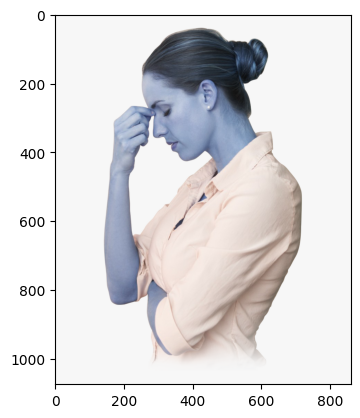

In [9]:
plt.imshow(img)
plt.show()

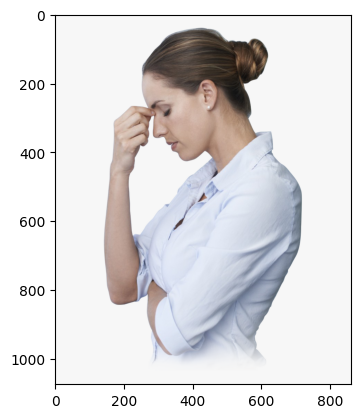

In [10]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exits:
        print('Image not in exit list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image', image_path)
      #os.remove(image_path)

### Load Dataset

In [12]:
#tf.keras.utils.image_dataset_from_directory?? for helping the tf load data

In [13]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 414 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [15]:
# get another batch from the iterator
batch = data_iterator.next()
# image representated as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [16]:
# class 1 = sad people
# class 0 = happy people
batch[1]

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int32)

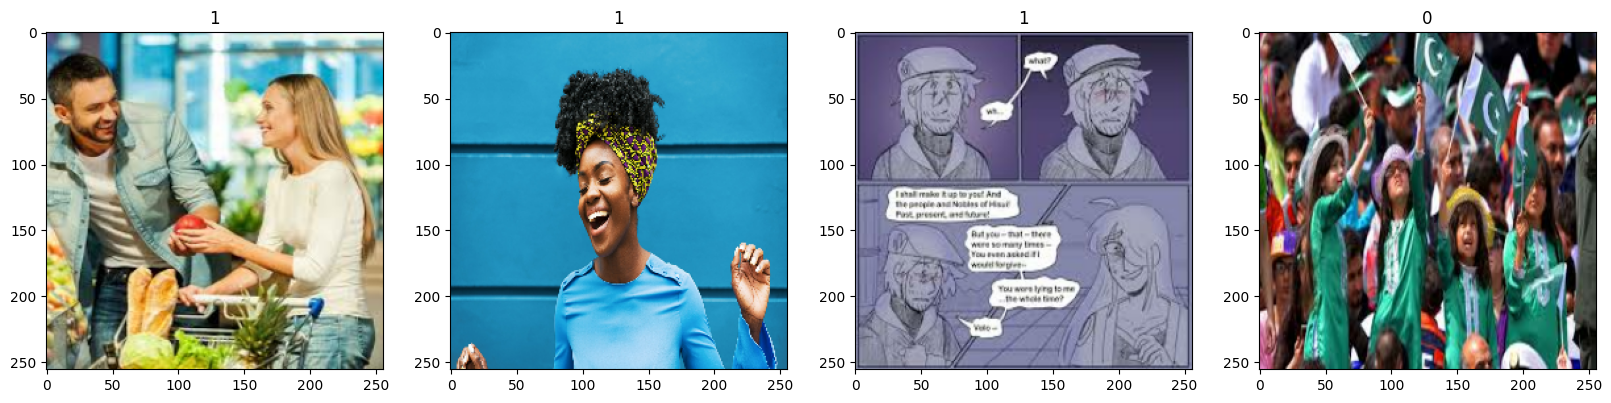

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### Scale Data (Preprocessing)

In [20]:
batch[0].shape

(32, 256, 256, 3)

In [21]:
batch[0].max()

255.0

In [22]:
scaled = batch[0] / 255
scaled.max()

1.0

In [23]:
data = data.map(lambda x,y: (x/255, y))

In [24]:
data.as_numpy_iterator().next()[0].max()

1.0

In [25]:
scaled_iterator = data.as_numpy_iterator()

In [26]:
batch = scaled_iterator.next()

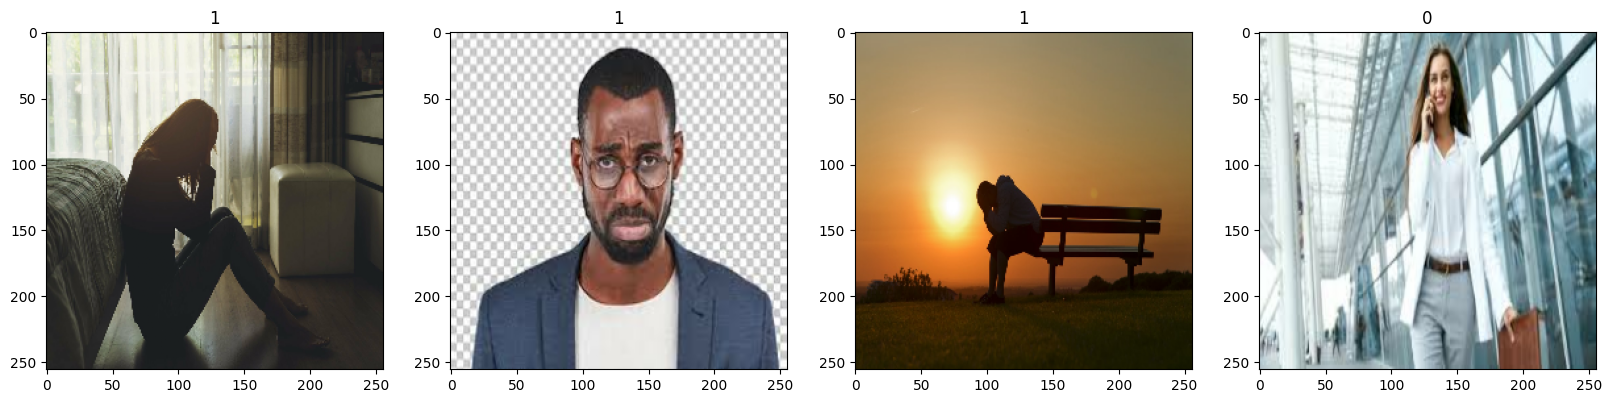

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

### Splitting Dataset

### Split Data

In [28]:
len(data)

13

In [40]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [41]:
train_size+val_size+test_size

13

In [42]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [46]:
len(test)

1

### Build Deep Learning model

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [48]:
model = Sequential()

In [49]:
# 16 filters of 3x3 shape, stride 1
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
#if there are binery class then use sigmoid and if there are more than 2 use softmax
model.add(Dense(1, activation='sigmoid'))


In [50]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [54]:
logdir = '/content/drive/MyDrive/datasets/sad_happy_clean_dataset/logs'

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [57]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
10/10 [==============================] - 10s 253ms/step - loss: 0.8553 - accuracy: 0.5625 - val_loss: 0.6134 - val_accuracy: 0.6250
Epoch 2/20
10/10 [==============================] - 5s 377ms/step - loss: 0.6000 - accuracy: 0.6719 - val_loss: 0.6015 - val_accuracy: 0.6406
Epoch 3/20
10/10 [==============================] - 5s 377ms/step - loss: 0.5927 - accuracy: 0.6531 - val_loss: 0.5724 - val_accuracy: 0.7969
Epoch 4/20
10/10 [==============================] - 4s 296ms/step - loss: 0.5636 - accuracy: 0.7406 - val_loss: 0.4374 - val_accuracy: 0.8281
Epoch 5/20
10/10 [==============================] - 5s 381ms/step - loss: 0.5181 - accuracy: 0.7531 - val_loss: 0.4479 - val_accuracy: 0.7812
Epoch 6/20
10/10 [==============================] - 5s 374ms/step - loss: 0.4228 - accuracy: 0.8188 - val_loss: 0.4802 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 4s 298ms/step - loss: 0.4289 - accuracy: 0.7937 - val_loss: 0.4108 - val_accuracy: 0.7812
Epoch

In [59]:
hist.history

{'loss': [0.8552898168563843,
  0.6000450253486633,
  0.5926588773727417,
  0.5636166334152222,
  0.5180517435073853,
  0.4228399395942688,
  0.42887458205223083,
  0.3233356475830078,
  0.24889922142028809,
  0.19365885853767395,
  0.15827330946922302,
  0.1086818128824234,
  0.07733074575662613,
  0.046528734266757965,
  0.02424822747707367,
  0.014153599739074707,
  0.012340687215328217,
  0.011857868172228336,
  0.008065002970397472,
  0.004165683872997761],
 'accuracy': [0.5625,
  0.671875,
  0.653124988079071,
  0.7406250238418579,
  0.753125011920929,
  0.8187500238418579,
  0.793749988079071,
  0.887499988079071,
  0.90625,
  0.921875,
  0.956250011920929,
  0.9624999761581421,
  0.981249988079071,
  0.987500011920929,
  1.0,
  1.0,
  0.996874988079071,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.6133689284324646,
  0.6014705896377563,
  0.572435200214386,
  0.4373828172683716,
  0.4479182958602905,
  0.48022615909576416,
  0.4107670783996582,
  0.30577775835990906,
  0.2181872576475

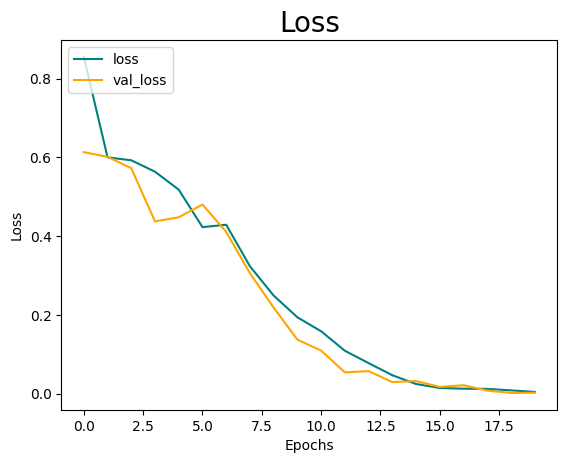

In [60]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

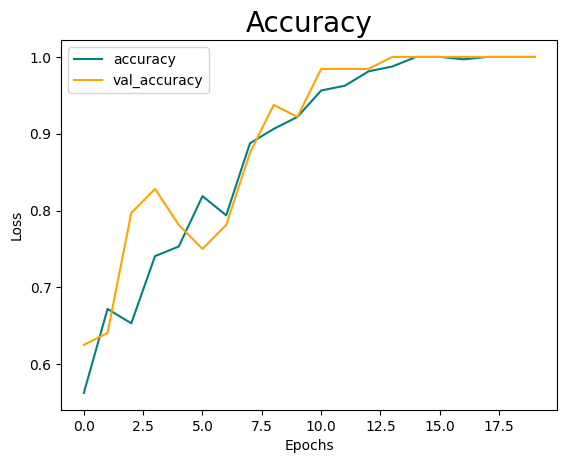

In [61]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

### Evaluate Model Perfomance

In [62]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [63]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [64]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 [==============================] - 1s 547ms/step


In [68]:
print(f'Precision: {precision.result()}, Recall: {recall.result()}, Accuracy: {accuracy.result()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


### Model Testing

In [69]:
import cv2

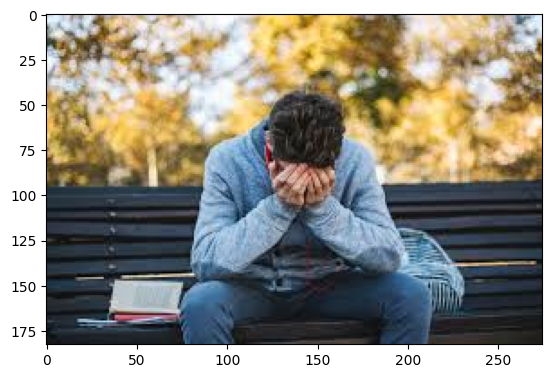

In [111]:
img = cv2.imread('/content/drive/MyDrive/datasets/sad_happy_clean_dataset/test/sad3.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

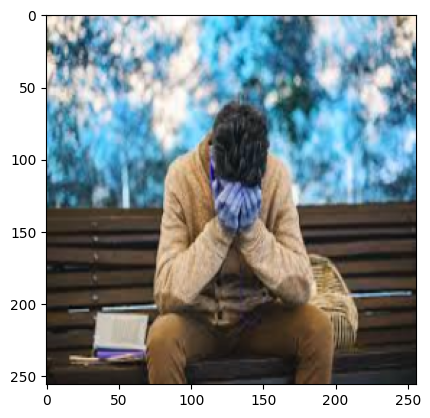

In [112]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [113]:
resize.shape

TensorShape([256, 256, 3])

In [114]:
np.expand_dims(resize/255, 0).shape

(1, 256, 256, 3)

In [115]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [116]:
yhat

array([[0.9984459]], dtype=float32)

In [110]:
if yhat > 0.5:
  print(f'Predicted Class is Sad')
else:
  print(f'Predicted Class is Happy')

Predicted Class is Sad


### Save Model

In [117]:
from tensorflow.keras.models import load_model

In [118]:
model.save(os.path.join('/content/drive/MyDrive/datasets/sad_happy_clean_dataset', 'happy_sad_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [119]:
new_model = load_model(os.path.join('/content/drive/MyDrive/datasets/sad_happy_clean_dataset', 'happy_sad_model.h5'))

In [121]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))


1/1 [==============================] - 0s 19ms/step


In [122]:
yhatnew

array([[0.9984459]], dtype=float32)

In [123]:
if yhatnew > 0.5:
  print(f'Predicted Class is Sad')
else:
  print(f'Predicted Class is Happy')

Predicted Class is Sad
